In [1]:
import json, yt
import matplotlib.pyplot as plt
import numpy as np

C:\Users\azton\Anaconda3\lib\site-packages\yt\utilities\logger.py:4: VisibleDeprecationWarning: The configuration file C:\Users\azton\.config\yt\ytrc is deprecated in favor of C:\Users\azton\.config\yt\yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: current_time              = 16.548159927217
yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: current_redshift          = 12.451325487595
yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: omega_radiation           = 0
yt : [INFO     ] 2021-08-02 10:41:34,115 Parameters: hubble_constant           = 0.6766


[   0.           28.50221216   30.56090303   38.73862296   40.81613756
   66.97204774   89.87903787   92.2330234    98.00062874  121.84754637
  162.43273441  164.77940432  185.8964581   216.67930647  229.33670569
  246.35423272  248.89774351  293.22117482  304.93047155  319.65789183
  327.52425051  342.95468886  355.44883989  358.70516087  378.60614963
  383.68683715  387.50767667  391.39899644  395.28822809  398.38238039
  407.33771885  429.84005721  433.64301832  439.49670472  490.73260118
  494.26323074  500.13197429  500.18032212  501.75934809  504.61596341
  512.80094221  514.06554114  531.27101586  543.455167    544.34249159
  545.66446068  551.44703755  592.15598074  622.68774663  662.0659047
  736.86295692  740.48294153  748.24706342  762.72616148  769.97029595
  812.13346006  834.90038927  876.52539659  883.3817244   916.20045753
  985.39629909 1003.16480211 1045.65970696 1079.30847851 1124.22606709
 1133.38634833 1369.23486681 1409.14730293 1430.35044027 1437.65735669
 1521.5

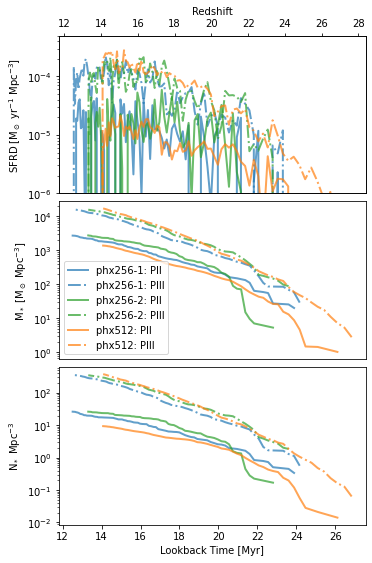

In [5]:
fig, ax = plt.subplots(3,1, figsize=(5.5,9))
axz = ax[0].twiny()
ds = yt.load('C:/Users/azton/Projects/phoenix/phx256-1/RD1250/RD1250')
sims = ['phx256-1','phx256-2', 'phx512']
outs = [1250, 1100, 980]
colors = ['tab:blue','tab:green', 'tab:orange'] #distinguish sims
linestyles = ['-','-.'] #for p2-p3
st_types = ['p2', 'p3']
type_lab = ['PII','PIII']
min_time = 1e20
max_time = 0
for i, sim in enumerate(sims):
    for j, star in enumerate(st_types):
        starfile = 'C:/Users/azton/Projects/phoenix_analysis/%s/RD%04d_%s_starfile.json'%(sim, outs[i], star)
        with open(starfile, 'r') as f:
            stardict = json.load(f)
        tend = float(max(stardict['birth']))
        tstart = float(min(stardict['birth']))
        if tend > max_time: max_time = tend
        if tstart < min_time: min_time = tstart
tbins = np.linspace(min_time, max_time, 100)
zbins = ds.cosmology.z_from_t(ds.arr(tbins, 'Myr'))
# print(min_time, max_time)
# print(zbins.min(), zbins.max())
for i, sim in enumerate(sims):
    for j, star in enumerate(st_types):
        starfile = 'C:/Users/azton/Projects/phoenix_analysis/%s/RD%04d_%s_starfile.json'%(sim, outs[i], star)
        box_size = 1.765 ** 3 if '256' in sim else 3.53 ** 3
        box_size /= 0.6766 ** 3 # Mpc instead of h^-1
        with open(starfile, 'r') as f:
            stardict = json.load(f)    
        # M*(t)

#         tend = float(max(stardict['birth']))
#         tstart = float(min(stardict['birth']))

        # bins for time
#         tbins = np.linspace(tstart, tend, 100) # Myr
        dt = (tbins[1] - tbins[0])*1e6 #yr
        mbins = np.zeros(101)
        nbins = np.zeros(101)
        for ii, t in enumerate(stardict['birth']):
            if stardict['mass'][ii] <= 300:
                tbin = np.digitize(t, tbins)
                mbins[tbin] += stardict['mass'][ii]
                nbins[tbin] += 1
        print(np.unique(mbins))
        cnum = np.array([nbins[:ii].sum() for ii in range(len(nbins))])
        cmass = np.array([mbins[:ii].sum() if mbins[ii] > 0 else 0 for ii in range(len(mbins))])
        
        dmdt = np.array([(cmass[ii] - cmass[ii-1])/dt if cmass[ii-1] > 0 else 0 for ii in range(1,len(cmass))]) \
                        / box_size
        
        tdmdt = tbins.max() - tbins # alter to lookback time
#         tdmdt = pbins

        h0 = axz.plot(zbins, dmdt, color=colors[i], linestyle = linestyles[j], linewidth=2, alpha=0.7)
        # axy.set_xlim(zdmdt[-1], zdmdt[0]) # reverse the axis so high z is to left
        h1 = ax[1].plot(zbins[cmass[1:] != 0], cmass[cmass != 0]/ box_size, 
                       color=colors[i], linestyle = linestyles[j], linewidth=2, alpha=0.7, label='%s: %s'%(sim, type_lab[j]))
        h2 = ax[2].plot(zbins[cmass[1:] != 0], cnum[cmass != 0]/ box_size, 
                       color=colors[i], linestyle = linestyles[j], linewidth=2, alpha=0.7)
# axz.set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].set_ylim(1e-6, 5e-4)
axz.set_xlabel('Redshift')
ax[0].set_ylabel('SFRD [M$_\odot$ yr$^{-1}$ Mpc$^{-3}$]')
ax[1].set_ylabel('M$_*$ [M$_\odot$ Mpc$^{-3}$]')
ax[2].set_ylabel('N$_*$ Mpc$^{-3}$')
ax[2].set_xlabel('Lookback Time [Myr]')
ax[0].set_xticks([])
ax[1].set_xticks([])
# ax[0].legend()
ax[1].legend()
plt.subplots_adjust(hspace=0.05)
plt.savefig('%s/P3-P2_SFR_combined.pdf'%('images'), bbox_inches='tight')